In [21]:
######################################################################
# This file copyright the Georgia Institute of Technology
#
# Permission is given to students to use or modify this file (only)
# to work on their assignments.
#
# You may NOT publish this file or make it available to others not in
# the course.
#
######################################################################

# Requirements to run the notebook

* Python 3.8+
* jupyter lab or jupyter notebook (not tested)
* numpy
* pandas
* plotly 

For the plotly installation see:  https://plotly.com/python/getting-started/

In [22]:
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
import pandas as pd

np.random.seed(1)

# Set up a Simple Model of an Object Undergoing Constant Acceleration

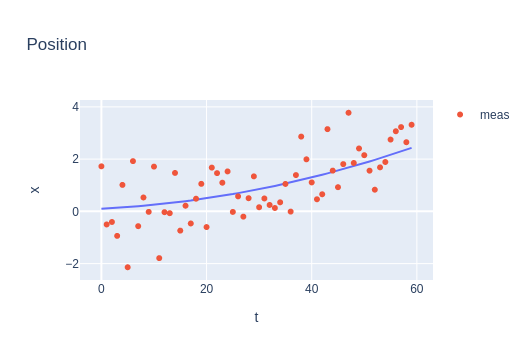

In [23]:
dt = 1.        # delta time step
sigma_r = 1.0  # measurement noise

# time sequence
t = np.arange(0.,60.,dt)

# Model constants
a = 0.001
b = 0.01
c = 0.1

## Constant acceleration dynamics model
x = a/2.*t**2 + b*t + c
v = a*t + b

## measurements
m = x + sigma_r*np.random.randn(len(t))

df = pd.DataFrame({'t':t, 'x':x,'v':v,'a':a})
fig = px.line(df, x='t',y = 'x', title='Position')

fig.add_trace(go.Scatter(name='meas', x=t, y=m, mode='markers'))

fig.show()

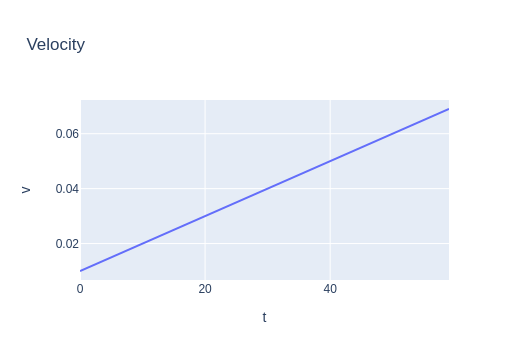

In [24]:
fig = px.line(df, x='t',y = 'v', title='Velocity')
fig.show()

# Construct a Linear Filter Based on a Constant Acceleration Model (see KF Tutorial) 

In [25]:
# State transition matrix
F = np.array([[1.,dt,0.5*dt**2],
              [0.,1., dt],
              [0.,0.,1.]])

# State to measurement matrix
H = np.array([[1.,0,0]])

# Measurement uncertainty matrix
R = np.array([[(1.5*sigma_r)**2]])
#R = np.array([[(1.*sigma_r)**2]])

# Initial covariance matrix
P = np.array([[25, 0, 0],
              [0., 1., 0],
              [0., 0., 0.01]])

# State noise model
Q = np.array([[0., 0, 0],
              [0., 0., 0],
              [0., 0., 0]])

# initial state estimate
xe = np.array([[m[0]],[0.],[0.]])

# arrays to record data for plotting
innov= np.zeros((len(t),1))
innovP = np.zeros((len(t),1))
xp = np.zeros((len(t),3))
Pp = np.zeros((len(t),3))


# loop over time updating measurements and predictions using the KF
for i,o in enumerate(m):
    z = np.array([[o]])
    
    # Update the state and covariance with the measurement
    S = H@P@H.T + R                # innovation covariance
    K = P@H.T@np.linalg.inv(S)     # kalman gain
    y = z-H@xe                     # innovation
    xe += K@y                      # state update
    P = (np.eye(3) - K@H)@P        # covariance update
    
    # Now predict for the next time step
    xe = F@xe                      # predicted state
    P = F@P@F.T + Q                # predicted covariance
    
    # Record data for plotting
    innov[i] = y.T
    innovP[i] = np.sqrt( np.diag(S) )
    xp[i] = xe.T
    Pp[i] = np.sqrt( np.diag(P) )
    


# Estimating/Filtering the Observed State

The Kalman Filter develops a filtered estimate of the observed state element based on the noise characteristics of the measurements and the noise model of the system.

* Plotting the "truth", the predicted estimate, the observations, and the predicted uncertainty on the same chart provides important insight into the KF's performance that can be used to help tune the filter
* The predicted covariance plotted as an envelope (i.e. +- truth) should nicely bound the estimated state 68% of the time or more. 

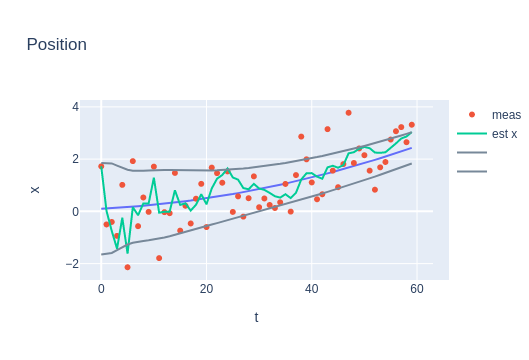

In [26]:
dfe = pd.DataFrame({'t':t, 'xp':xp[:,0],'vp':xp[:,1],'ap':xp[:,2], 'Px':Pp[:,0], 'Pv':Pp[:,1], 'Pa':Pp[:,2]})
fig = px.line(df, x='t',y = 'x', title='Position')
fig.add_trace(go.Scatter(name='meas',x=t, y=m, mode='markers'))

fig.add_trace(go.Scatter(name='est x', x=dfe['t'], y= dfe['xp']))
fig.add_trace(go.Scatter(name='$\sigma$', x=dfe['t'], y= x + dfe['Px'], marker = dict( color = 'LightSlateGrey')))
fig.add_trace(go.Scatter(name='$\sigma$', x=dfe['t'], y= x - dfe['Px'], marker = dict( color = 'LightSlateGrey')))


fig.show()

# The Kalman Filter Can Estimate the Unobserved States

Because of the correlation between the state variables modeled in the state transition matrix $F$, the Kalman filter is able to estimate the states that are not directly observed.

* Similar to the observed position, the predicted covariance should bound the error at least 68% of the time
* When "truth" is available for these states this is a powerful way to evaluate the Kalman Filter's performance for the inferred states.

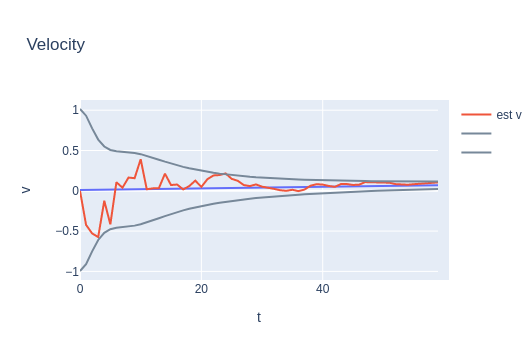

In [27]:
fig = px.line(df, x='t',y = 'v', title='Velocity')
fig.add_trace(go.Scatter(name='est v', x=dfe['t'], y=dfe['vp']))

fig.add_trace(go.Scatter(name='$\sigma$', x=dfe['t'], y= v + dfe['Pv'], marker = dict( color = 'LightSlateGrey')))
fig.add_trace(go.Scatter(name='$\sigma$', x=dfe['t'], y= v - dfe['Pv'], marker = dict( color = 'LightSlateGrey')))
fig.show()

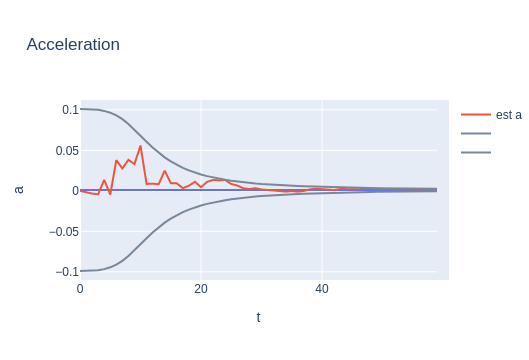

In [28]:
fig = px.line(df, x='t',y = 'a', title='Acceleration')
fig.add_trace(go.Scatter(name='est a', x=dfe['t'], y=dfe['ap']))

fig.add_trace(go.Scatter(name='$\sigma$', x=dfe['t'], y= df['a'] + dfe['Pa'], marker = dict( color = 'LightSlateGrey')))
fig.add_trace(go.Scatter(name='$\sigma$', x=dfe['t'], y= df['a'] - dfe['Pa'], marker = dict( color = 'LightSlateGrey')))

fig.show()

# Another view of the Kalman Filter Performance

We use the innovation sequence, $y$ and the innovation covariance, $S$

* The sequence should appear random, like a white noise sequence
* $+-\sigma$ should bound approximately 68% of the innovations
* Very useful when no truth model is available


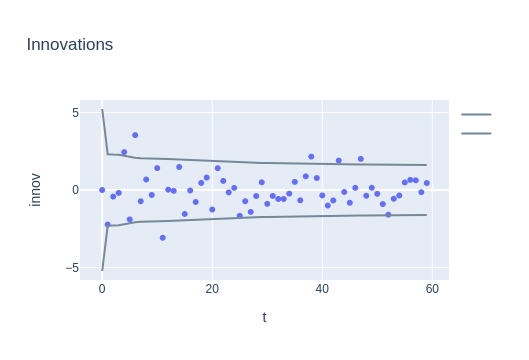

In [30]:
dfi = pd.DataFrame({'t':t,'innov':innov[:,0],'innovP':innovP[:,0]})
fig = px.scatter(dfi, x='t',y = 'innov', title='Innovations')

fig.add_trace(go.Scatter(name='$\sigma$', x=dfi['t'], y= +dfi['innovP'], marker = dict( color = 'LightSlateGrey')))
fig.add_trace(go.Scatter(name='$\sigma$', x=dfi['t'], y= -dfi['innovP'], marker = dict( color = 'LightSlateGrey')))


fig.show()